We import our three agents and supporting libraries.

In [11]:
import sys
sys.path.append("../src")

import pandas as pd
import numpy as np
import random

from strategy_agent import StrategyAgent
from risk_agent import RiskAgent
from allocator_agent import AllocatorAgent


In [12]:
data = pd.read_csv("../data/AAPL_enriched.csv", index_col=0, parse_dates=True)

In [16]:
def compute_metrics(df):
    if "Strategy_Return" in df.columns:
        returns = df["Strategy_Return"]
    elif "Portfolio_Return" in df.columns:
        returns = df["Portfolio_Return"]
    else:
        raise KeyError("No valid return column found")
    
    strat_curve = (1 + returns.fillna(0)).cumprod()
    years = (returns.index[-1] - returns.index[0]).days / 365.25
    cagr = strat_curve.iloc[-1]**(1/years) - 1 if years > 0 else 0
    vol = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252)) if returns.std() > 0 else 0
    roll_max = strat_curve.cummax()
    dd = (strat_curve / roll_max - 1).min()
    return {"CAGR": cagr, "Volatility": vol, "Sharpe": sharpe, "MaxDD": dd}



Loop up to 3 attempts.

Each attempt: StrategyAgent generates strategies with random params.

RiskAgent filters. AllocatorAgent builds portfolio.

RiskAgent checks portfolio. If FAIL → retry.

In [17]:
def closed_loop(data, max_attempts=3):
    attempt = 0
    portfolio = None
    decision = "FAIL"
    notes = []

    while attempt < max_attempts and decision == "FAIL":
        attempt += 1
        print(f"\nAttempt {attempt} -----------------")
        
        # Step 1: Generate strategies with varied params
        agent = StrategyAgent(data)
        strategies = {
            f"SMA_{attempt}": agent.sma_crossover(fast=random.choice([5,10,15]), slow=random.choice([50,100])),
            f"RSI_{attempt}": agent.rsi_strategy(lower=random.choice([25,30]), upper=random.choice([70,75])),
            f"BB_{attempt}": agent.bollinger_breakout()
        }
        
        # Step 2: Metrics
        metrics = {name: compute_metrics(df) for name, df in strategies.items()}
        
        # Step 3: Risk checks at strategy level
        risk_agent = RiskAgent(sharpe_min=1.0, max_dd=-0.25, vol_max=0.3)
        risk_assessments = {name: risk_agent.assess(m) for name, m in metrics.items()}
        
        # Step 4: Allocation
        allocator = AllocatorAgent(method="sharpe")
        weights, portfolio = allocator.allocate(strategies, metrics, risk_assessments)
        
        if portfolio is None:
            print("No strategies passed individual risk checks.")
            continue
        
        # Step 5: RiskAgent evaluates the PORTFOLIO
        portfolio_metrics = compute_metrics(portfolio)
        portfolio_assessment = risk_agent.assess(portfolio_metrics)
        
        print("Portfolio metrics:", portfolio_metrics)
        print("Assessment:", portfolio_assessment)
        
        decision = portfolio_assessment["Decision"]
        notes = portfolio_assessment["Notes"]
        
    return portfolio, decision, notes



Attempt 1 -----------------
Portfolio metrics: {'CAGR': np.float64(0.13984910882294188), 'Volatility': np.float64(0.04382244081992633), 'Sharpe': np.float64(2.9944674019850326), 'MaxDD': np.float64(-0.007035576834644064)}
Assessment: {'Decision': 'PASS', 'Notes': ['All risk checks passed']}

Final Decision: PASS
Notes: ['All risk checks passed']


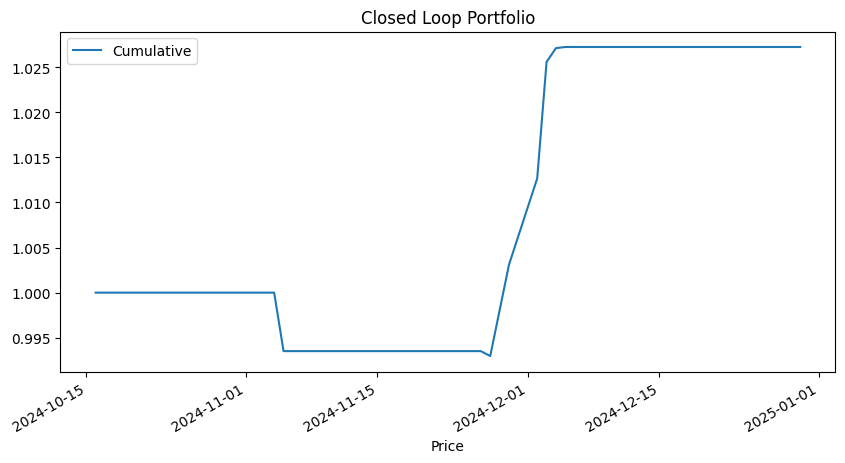

In [18]:
portfolio, decision, notes = closed_loop(data)

print("\nFinal Decision:", decision)
print("Notes:", notes)

if portfolio is not None:
    portfolio[["Cumulative"]].plot(title="Closed Loop Portfolio", figsize=(10,5))


In [19]:
import os
from datetime import datetime

os.makedirs("../logs", exist_ok=True)

if portfolio is not None:
    portfolio.to_csv("../logs/Day15_closed_loop_portfolio.csv")
    
with open("../logs/Day15_summary.txt", "w") as f:
    f.write(f"Day 15 run ({datetime.today().date()})\n")
    f.write(f"Decision: {decision}\n")
    f.write("Notes: " + "; ".join(notes))
